In [1]:
import uproot
import numpy as np
import torch
import jax.numpy as jnp
import jraph
import jax.random as jrandom
import jax.tree_util as tree
import jax
import flax 
import haiku as hk
from typing import Any, Callable, Dict, List, Optional, Tuple
import optax


In [2]:
f = uproot.open("tksim_bg2.0_file87.root")
trees = f['tksim']
cell_variables = ['yDigY', 'yDigX', 'yDigPdgId', 'yDigZ']
events = trees['yDigZ']

nevents_tot = int(trees.num_entries)
X_tot = np.asarray(trees['yDigX'])/1000
Y_tot = np.asarray(trees['yDigY'])/1000
Z_tot = np.asarray(trees['yDigZ'])/1000
ID_tot = np.asarray(trees['yDigPdgId'])
arrays = np.asarray((X_tot, Y_tot, Z_tot, ID_tot))



In [3]:
arrays.shape

(4, 100000)

In [4]:
#function that compute the node number (hit number) for each graph (event) in the batch
def get_node_number(arrays, batch_size):
    node_numbers = []
    x = arrays[0]
    
    for i in range(batch_size):
        
        xx = x[i]
        node_numbers.append([xx.shape[0]])
    max_value = np.max(node_numbers)
    
    return node_numbers, max_value

#function that returns the n_nodes and n_edges vectors required for defining the GraphTuple
#n_nodes vector is like ([a],[b],[c]) with a,b,c nodes numbers for each graph in the batch
#n_edges vector is like ([a**2], [b**2], [c**2]) where each element is the number of edges for the graph (fully connected)

def get_nodes_edges_per_event(arrays, batch_size):
    data_array = get_node_number(arrays, batch_size)[0]

    hits_per_event = data_array
    edges_per_event = [[nhits[0]**2] for nhits in data_array]
    return hits_per_event, edges_per_event


#function that creates for each graoh in the batch the vectors defining senders and receivers
#explicitly batched graph is used so all the vectors are padded to the dimension of the bigger one 

def create_senders_receivers(arrays, batch_size):
    nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    senders = []
    receivers = []
    for nhit in nhits:
        n = nhit[0]
        s = torch.arange(n).repeat(n).tolist()
        r = torch.repeat_interleave(torch.arange(n), n).tolist()
        
        senders.append(s)
        receivers.append(r)

    padded_senders = []
    padded_receivers = []
    max_value = get_node_number(arrays, batch_size)[1]

    for sender in senders:
        pad_s = sender + [-1] * (max_value**2 - len(sender))
        padded_senders.append(pad_s)

    for receiver in receivers:
        pad_r = receiver + [-1] * (max_value**2 - len(receiver))
        padded_receivers.append(pad_r)

    return padded_senders, padded_receivers


#function that decorates the target nodes with only the particle id (muon == -13.)
def decorate_nodes_truth(arrays, batch_size):
    nodes = []
    max_value = get_node_number(arrays, batch_size)[1]
    
    for i in range (0, batch_size):        
        id = np.asarray(arrays[3][i])
        padded_id =  jnp.pad(id, (0, max_value - len(id)), mode='constant')
        node_features = jnp.stack((padded_id), axis=-1)
        nodes.append(node_features)

    return nodes

#function that decorates the input nodes with (y,z) coordinates
def decorate_nodes(arrays,batch_size):
    nodes = []
    max_value = get_node_number(arrays, batch_size)[1]    
    for i in range (0, batch_size):
        y = np.asarray(arrays[1][i])
        z = np.asarray(arrays[2][i])
        padded_y =  jnp.pad(y, (0, max_value - len(y)), mode='constant')
        padded_z =  jnp.pad(z, (0, max_value - len(z)), mode='constant')
      
        node_features = jnp.stack((padded_y,padded_z), axis=-1)
        nodes.append(node_features)

    return nodes


In [5]:
def GetGraphs(arrays: np.ndarray, batch_size : int) -> jraph.GraphsTuple:
    graph = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    graph_truth = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes_truth(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    return (graph, graph_truth)



In [6]:
graph = GetGraphs(arrays, 5)[0]
graph_truth = GetGraphs(arrays,5)[1]

In [7]:
print(graph.nodes.shape)
print(graph_truth.nodes.shape)

(5, 342, 2)
(5, 342)


In [8]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

In [9]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    #total_num_nodes = sum(graph.n_node)[0]
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

In [10]:
import jax.numpy.linalg as LA
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  '''
  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.nets.MLP([300, 100, 100])(x)
  '''
  def _attention_logit_fn(s, r, e_):
    del e_
    return (s == r)*1 + (s != r)*-1e10

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(100)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.nets.MLP([300, 100, 100])(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.nets.MLP([100, 100, 100]),
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.nets.MLP([100, 100, 100])(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.nets.MLP([20, 100, 100]),
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.nets.MLP([20, 100, 100])(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(1),
      add_self_edges=True)
  graph = gn(graph)
  '''
  nodes,_, receivers, senders, _,_ ,_  = graph
  print('------', jnp.isnan(nodes))
  update_node_fn = lambda nodes: LA.norm(nodes, axis=-1)
  nodes = update_node_fn(nodes)
  out_graph = graph._replace(nodes=nodes)
  print('---------', jnp.isnan(out_graph.nodes))
  return out_graph
  '''
  return graph

In [11]:
start_d = 0
end_d = 4
batch_size = 2
arrays = np.asarray((X_tot[start_d:end_d], Y_tot[start_d:end_d], Z_tot[start_d:end_d], ID_tot[start_d:end_d]))
print(arrays.shape)

graph = GetGraphs(arrays, batch_size)[0]
graph_truth = GetGraphs(arrays,batch_size)[1]

network = hk.without_apply_rng(hk.transform( hk.vmap(gat_definition, split_rng=False)))
params = network.init(jax.random.PRNGKey(42), graph)
output_graph = network.apply(params, graph)


def preprocessing_4loss(output_graph, target_graph):
    features = output_graph.nodes
    nhit  = output_graph.n_node
    
    # Generate the desired output
    max_value = jnp.max(nhit)
    out = jnp.arange(max_value) < jnp.repeat(nhit, max_value, axis=1)
    targ = jnp.arange(max_value) < jnp.repeat(nhit, max_value, axis=1)
    out = jnp.array(out)
    targ = jnp.array(targ)
    return out, targ
    
        
output_graph4loss , target_graph4loss = preprocessing_4loss(output_graph, graph_truth)


(4, 4)


In [28]:
print('graph.n_node[1]')
print(output_graph.nodes[1])
print('----------------------------------------------')
print('graph_truth.nodes[1]')
print(graph_truth.nodes[1])
print('----------------------------------------------')
print('graph_truth.nodes[1].shape')
print(graph_truth.nodes[1].shape)
print('----------------------------------------------')
r = output_graph.nodes[1].ravel()
print('SHAPE R:', r.shape)
print('----------------------------------------------')
masked_target = preprocessing_4loss(output_graph, graph_truth)[1]
print('masked_target[1]')
print(masked_target[1])
print('----------------------------------------------')
bkg_loss = r**2
print('LOSS SHAPE:', bkg_loss.shape)
print('----------------------------------------------')
masked_bkg_loss = jnp.where(masked_target[1] == True, bkg_loss, 0)
print('masked_bkg_loss')
print(masked_bkg_loss)
print('----------------------------------------------')
print('COUNT NONZERO MASKED_BKG_LOSS >>>> ', jnp.count_nonzero(masked_bkg_loss), ' >>> jnp.where(masked_target[1] == True, bkg_loss, 0)')
print('----------------------------------------------')
masked_bkg_hit_loss = jnp.where((jnp.absolute(graph_truth.nodes[1]) != 13.0) , masked_bkg_loss, 0)
print('masked_bkg_hit_loss')
print(masked_bkg_hit_loss)
print('----------------------------------------------')
print('COUNT NONZERO MASKED_BKG_HIT_LOSS >>>> ', jnp.count_nonzero(masked_bkg_hit_loss),' >>> jnp.where((jnp.absolute(graph_truth.nodes[1]) != 13.0) , masked_bkg_loss, 0)' )

graph.n_node[1]
[[-0.00037293]
 [-0.00037282]
 [-0.00037277]
 [-0.00037271]
 [-0.00037263]
 [-0.00044733]
 [-0.00044723]
 [-0.00044712]
 [-0.00044701]
 [-0.0004469 ]
 [-0.0005214 ]
 [-0.00059471]
 [-0.00059498]
 [-0.00059525]
 [-0.00066752]
 [-0.00066787]
 [-0.00066818]
 [-0.00066845]
 [-0.0007408 ]
 [-0.00074093]
 [-0.00074125]
 [-0.0007416 ]
 [-0.00081442]
 [-0.00081452]
 [-0.00081466]
 [-0.00184522]
 [-0.00184532]
 [-0.00184542]
 [-0.00184552]
 [-0.00184563]
 [-0.00191904]
 [-0.00191915]
 [-0.00191925]
 [-0.00191934]
 [-0.00199287]
 [-0.00199297]
 [-0.00199307]
 [-0.00206679]
 [-0.00310441]
 [-0.00310469]
 [-0.00310497]
 [-0.00317871]
 [-0.00317898]
 [-0.00317925]
 [-0.00317953]
 [-0.00325327]
 [-0.00325355]
 [-0.00325382]
 [-0.0032541 ]
 [-0.00325437]
 [-0.00332839]
 [-0.0003613 ]
 [-0.00033272]
 [-0.00033267]
 [-0.00028108]
 [-0.00028134]
 [-0.00029875]
 [-0.00029877]
 [-0.00029879]
 [-0.00029881]
 [-0.0003192 ]
 [-0.00031868]
 [-0.00031818]
 [-0.00031764]
 [-0.00029907]
 [-0.0002

In [26]:

def preprocessing_4loss(output_graph, target_graph):
    features = output_graph.nodes
    nhit  = output_graph.n_node
    
    # Generate the desired output
    max_value = jnp.max(nhit)
    out = jnp.arange(max_value) < jnp.repeat(nhit, max_value, axis=1)
    targ = jnp.arange(max_value) < jnp.repeat(nhit, max_value, axis=1)
    out = jnp.array(out)
    targ = jnp.array(targ)
    return out, targ
    
        
output_graph4loss , target_graph4loss = preprocessing_4loss(output_graph, graph_truth)

In [19]:
start_d = 0
end_d = 4
batch_size = 2
arrays = np.asarray((X_tot[start_d:end_d], Y_tot[start_d:end_d], Z_tot[start_d:end_d], ID_tot[start_d:end_d]))
arrays.shape


(4, 4)

In [20]:
graph = GetGraphs(arrays, batch_size)[0]
graph_truth = GetGraphs(arrays,batch_size)[1]

In [21]:
def DataLoader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    
    print('n_events: ', dataset_size, ', batch_size: ', batch_size)
     
    #assert all(array.shape[0] == dataset_size for array in arrays)
   
        
    (key,) = jrandom.split(key, 1)
    start = 0
    end = batch_size
    #print('->', end)
    while end <= dataset_size:
        
        yield tuple(GetGraphs(arrays[:,start:end], batch_size))
        start = end
        end = start + batch_size
        #print('--->', end)

#print(next(dataloader))

In [22]:
dataloader = DataLoader(arrays, batch_size, key = jrandom.PRNGKey(68743))

for x in dataloader:

    print(np.asarray(x).shape)
    input = x[0]
    target = x[1]
    print('-',input.n_node.T)
    print('--',target.n_node.T)



n_events:  4 , batch_size:  2


/home/lrambelli/miniconda3/envs/vannolil_CNN_Image_Segmentation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(2, 7)
- [[197 172]]
-- [[197 172]]
(2, 7)
- [[206 188]]
-- [[206 188]]


In [23]:
print(graph.n_node)
print(graph_truth.nodes.ravel()[:196])
print(graph_truth.nodes.ravel()[197:])

[[197]
 [172]]
[-13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
 -13  22  22  22  22  22  22  22   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[-13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -1

In [24]:
network = hk.without_apply_rng(hk.transform( hk.vmap(gat_definition, split_rng=False)))
params = network.init(jax.random.PRNGKey(42), graph)
print(params.keys())
print(params['linear']['b'].shape,  params['linear_1']['w'].shape, params['mlp/~/linear_0']['w'].shape, params['mlp/~/linear_1']['w'].shape, params['mlp/~/linear_2']['w'].shape)

opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(params)

steps = 500
iter_data = DataLoader(arrays, batch_size, key = jrandom.PRNGKey(68743))
iter_data = list(iter_data)

#iter_data = list(iter_data)

loss_list = []
muon_loss_list = []
bkg_loss_list = []


def muon_loss(output_graph, target_graph):
        
        radius = output_graph.nodes
        radius = jnp.reshape(radius, (radius.shape[0], radius.shape[1]))
        output_mask, target_mask = preprocessing_4loss(output_graph, target_graph)
        id_mask = target_graph.nodes

        muon_loss = (radius)**2        
        masked_loss = jnp.where(output_mask ==  True, muon_loss, 0)
        masked_muon_loss = jnp.where(jnp.absolute(id_mask) == 13.0, masked_loss, 0)
        muon_loss_list.append(masked_muon_loss.sum() / jnp.count_nonzero(masked_muon_loss))
        return masked_muon_loss.sum() / jnp.count_nonzero(masked_muon_loss)

def bkg_loss(output_graph, target_graph):
        
        radius = output_graph.nodes
        radius = jnp.reshape(radius, (radius.shape[0], radius.shape[1]))
        output_mask, target_mask = preprocessing_4loss(output_graph, target_graph)
        id_mask = target_graph.nodes
        bkg_loss = (radius -1)**2
        #bkg_loss = (1/(radius+epsilon))**2
        masked_bkg_loss = jnp.where(target_mask == True, bkg_loss, 0)
        masked_bkg_hit_loss = jnp.where((jnp.absolute(id_mask) != 13.0) , masked_bkg_loss, 0)
        bkg_loss_list.append(masked_bkg_hit_loss.sum() / jnp.count_nonzero(masked_bkg_hit_loss))
        return masked_bkg_hit_loss.sum() / jnp.count_nonzero(masked_bkg_hit_loss)

def prediction_loss(params, input_graph, target_graph):

        output_graph = network.apply(params, input_graph)
        print('MUON LOSS: ', muon_loss(output_graph, target_graph), 'BKG LOSS: ', bkg_loss(output_graph, target_graph))
        
        return muon_loss(output_graph, target_graph) + bkg_loss(output_graph, target_graph)

'''
def prediction_loss(params, input_graph, target_graph):
        
        output_graph = network.apply(params, input_graph)
        radius = output_graph.nodes
        radius = jnp.reshape(radius, (radius.shape[0], radius.shape[1]))
        #print('RADIUS NAN ', jnp.isnan(radius))
       
        # taking masks for zero padding
        output_mask, target_mask = preprocessing_4loss(output_graph, target_graph)
        output_mask = output_mask
        target_mask = target_mask
        # taking mask for muon 
        id_mask = target_graph.nodes
        #print('ID MASK SHAPE   ', id_mask.shape)
        #print('TARG MASK SHAPE ', target_mask.shape)

        muon_loss = (radius)**2        
        masked_loss = jnp.where(output_mask ==  True, muon_loss, 0)
        masked_muon_loss = jnp.where(jnp.absolute(id_mask) == 13.0, masked_loss, 0)

        bkg_loss = (radius - 10)**2
        #bkg_loss = (1/(radius+epsilon))**2
        masked_bkg_loss = jnp.where(target_mask == True, bkg_loss, 0)
        masked_bkg_hit_loss = jnp.where((jnp.absolute(id_mask) != 13.0) , masked_bkg_loss, 0)
        print('MUON LOSS: ', masked_muon_loss, jnp.count_nonzero(masked_muon_loss))
        print('BKG LOSS:  ', masked_bkg_hit_loss, jnp.count_nonzero(masked_bkg_hit_loss))
        
       
        #masked_muon_loss = jnp.where(jnp.absolute(id_mask)== 13., muon_loss, 0)

        return jnp.sum(masked_bkg_hit_loss)/jnp.count_nonzero(masked_bkg_hit_loss) + 100 * jnp.sum(masked_muon_loss)/jnp.count_nonzero(masked_muon_loss)
        #(masked_muon_loss/jnp.count_nonzero(masked_muon_loss))) # + 
'''
@jax.jit
def update(params, opt_state, gr):
        """Returns updated params and state."""
        #g = jax.grad(prediction_loss)(params, output_graph, target_graph)
        updates, opt_state = opt_update(gr, opt_state)
        return optax.apply_updates(params, updates), opt_state


for step in range (1, steps+1):
    
        epoch_loss = 0

        for g in iter_data:
                input_graph = g[0]
                truth_graph = g[1]
                
                print('INPUT GRAPH SHAPE ',  np.asarray(input_graph).shape)
                print('INPUT GRAPH NODES ', input_graph.n_node.T)
                loss = prediction_loss(params, input_graph, truth_graph)
                
                #(_, output_graph), grads = jax.value_and_grad(prediction_loss, has_aux=True, argnums=0)(params, input_graph, truth_graph)
                gr = jax.grad(prediction_loss, argnums=0)(params, input_graph, truth_graph)
                #print('GRAD NAN  ', grads.keys())
                #print('PARAMS NAN ', params.keys())
                epoch_loss = epoch_loss + loss
               
                params, opt_state = update(params, opt_state, gr)

        print('--------------------->  STEP: ', step, ' LOSS: ', epoch_loss)
        loss_list.append(epoch_loss)
   

dict_keys(['linear', 'linear_1', 'mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2', 'mlp_1/~/linear_0', 'mlp_1/~/linear_1', 'mlp_1/~/linear_2', 'mlp_2/~/linear_0', 'mlp_2/~/linear_1', 'mlp_2/~/linear_2', 'mlp_3/~/linear_0', 'mlp_3/~/linear_1', 'mlp_3/~/linear_2', 'mlp_4/~/linear_0', 'mlp_4/~/linear_1', 'mlp_4/~/linear_2'])
(100,) (100, 1) (100, 100) (100, 100) (100, 100)
n_events:  4 , batch_size:  2
INPUT GRAPH SHAPE  (7,)
INPUT GRAPH NODES  [[197 172]]


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/2)>
It arose in jax.numpy.arange argument `stop`.
The error occurred while tracing the function muon_loss at /tmp/ipykernel_8423/3746869539.py:19 for xla_call. This concrete value was not available in Python because it depends on the value of the argument 'output_graph'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

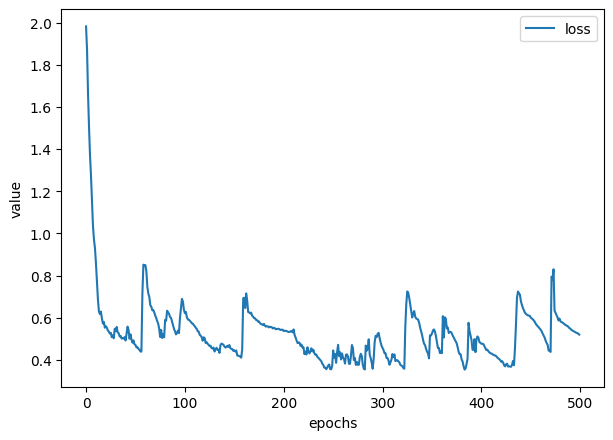

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7, 5), dpi=100)
xrange = np.arange(0,500,1)
plt.plot(xrange, np.asarray(loss_list), label = 'loss')
#plt.plot(xrange, np.asarray(muon_loss_list), label = 'muon')
#plt.plot(xrange, np.asarray(bkg_loss_list), label = 'bkg')
plt.xlabel('epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [ ]:
predicted_graph = network.apply(params, graph)

In [ ]:
predicted_radius = predicted_graph.nodes
predicted_radius = np.reshape(predicted_radius, (predicted_radius.shape[0], predicted_radius.shape[1]))
o = predicted_radius.flatten()
r = o
r.shape


(394,)

In [ ]:
masked_output, masked_target = preprocessing_4loss(predicted_graph, graph_truth)
masked_loss = jnp.where(masked_output.ravel() ==  True, r, 0)
masked_muon_loss = jnp.where(jnp.absolute(graph_truth.nodes.ravel()) == 13.0, masked_loss, 0)
print(masked_muon_loss)
non_zero_values_sig = np.asarray([value for value in masked_muon_loss if value != 0])

[0.6311739  0.62429976 0.61958605 0.5885508  0.5870249  0.58553135
 0.57576185 0.5758867  0.5757013  0.57517105 0.5747366  0.5599047
 0.5586127  0.5571897  0.5557221  0.49898612 0.43579277 0.43314114
 0.4304894  0.37500328 0.37269214 0.3147372  0.31220093 0.30712068
 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799
 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799
 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799
 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799
 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799 0.17044799
 0.17044799 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

In [ ]:
print('graph.n_node[1]')
print(predicted_graph.n_node)
print('----------------------------------------------')
print('graph_truth.nodes[1]')
print(graph_truth.nodes)
print('----------------------------------------------')
print('graph_truth.nodes[1].shape')
print(graph_truth.nodes[1].shape)
print('----------------------------------------------')
out = predicted_graph.nodes.ravel()
r = out
print('SHAPE R:', r.shape)
print('----------------------------------------------')
masked_target = preprocessing_4loss(output_graph, graph_truth)[1]
print('masked_target[1]')
print(masked_target)
print('----------------------------------------------')
bkg_loss = r
print('LOSS SHAPE:', bkg_loss.shape)
print('----------------------------------------------')
masked_bkg_loss = jnp.where(masked_target.ravel() == True, bkg_loss.ravel(), 0)
print('masked_bkg_loss')
print(masked_bkg_loss)
print('----------------------------------------------')
print('COUNT NONZERO MASKED_BKG_LOSS >>>> ', jnp.count_nonzero(masked_bkg_loss), ' >>> jnp.where(masked_target[1] == True, bkg_loss, 0)')
print('----------------------------------------------')
masked_bkg_hit_loss = jnp.where((jnp.absolute(graph_truth.nodes.ravel()) != 13.0) , masked_bkg_loss, 0)
print('masked_bkg_hit_loss')
print(masked_bkg_hit_loss)
print('----------------------------------------------')
print('COUNT NONZERO MASKED_BKG_HIT_LOSS >>>> ', jnp.count_nonzero(masked_bkg_hit_loss),' >>> jnp.where((jnp.absolute(graph_truth.nodes[1]) != 13.0) , masked_bkg_loss, 0)' )

graph.n_node[1]
[[197]
 [172]]
----------------------------------------------
graph_truth.nodes[1]
[[-13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
  -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
  -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
  -13  22  22  22  22  22  22  22   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [-13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13 -13
  -13 -13 -13 -1

0.17044799 1.0136548


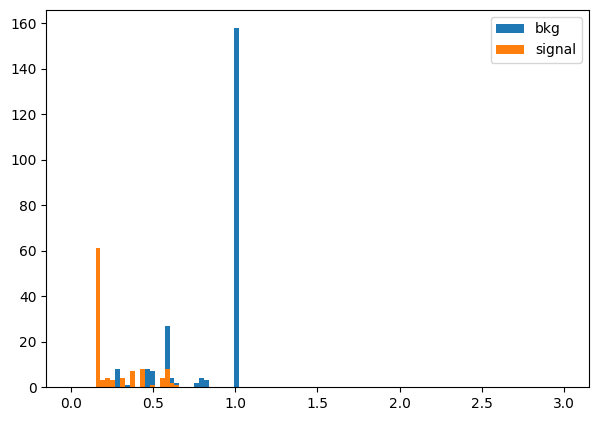

In [ ]:
import matplotlib.pyplot as plt 
non_zero_values_bkg = np.asarray([value for value in masked_bkg_hit_loss if value != 0])
plt.figure(figsize=(7, 5), dpi=100)
print(np.min(non_zero_values_bkg), np.max(non_zero_values_bkg))

plt.hist(non_zero_values_bkg, bins=100, range = [0,3], label = 'bkg')
plt.hist(non_zero_values_sig, bins = 100, range = [0,3], label = 'signal')

plt.legend()
plt.show()

(394,)
288
0.17044799 1.0136548


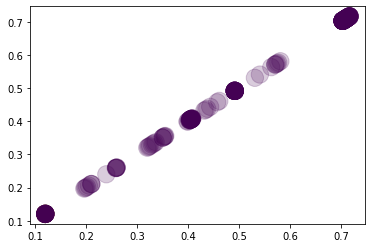

In [ ]:
import matplotlib.pyplot as plt 
target = graph_truth.nodes.ravel()
prepr_output, prepr_target = preprocessing_4loss(predicted_graph, graph_truth)

print(r.shape)
bkg = r[abs(target) != 13.]
print(jnp.count_nonzero(bkg))

print(np.min(bkg), np.max(bkg))

x = bkg * (1/np.sqrt(2))
y = bkg * (1/np.sqrt(2))
colors = target[abs(target) != 13] +2


plt.scatter(x, y,s=300,c=colors, alpha=0.2)

plt.show()


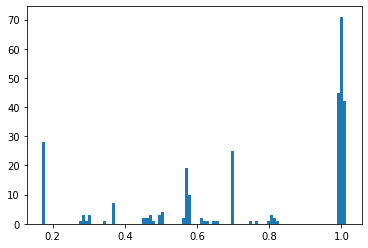

In [ ]:
plt.hist(bkg, bins=100)
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
r1 = r.ravel()
t1 = graph_truth.nodes.ravel()

mu = r1[abs(t1)==13]
bkg = r1[abs(t1)!=13]
print(mu.shape, bkg.shape)
print(np.min(bkg), np.max(bkg))
plt.figure(figsize=(7, 5), dpi=100)
plt.hist(mu**2, bins=20,  alpha = 0.5, label = 'mu', range = [0,4])
plt.hist(bkg**2, bins=20,  alpha = 0.5, label= 'bkg', range= [0,4])
plt.legend()
plt.show()

(106,) (288,)
0.17044799 1.0136548


In [ ]:
print(predicted_radius[0].shape)
print(graph_truth.nodes[0].shape)
target = graph_truth.nodes.flatten()
pred_mu = r[abs(target)==13]
pred_bkg = r[abs(target) != 13]

print(np.min(r), np.max(r))

(197,)
(197,)
0.17044799 1.0136548


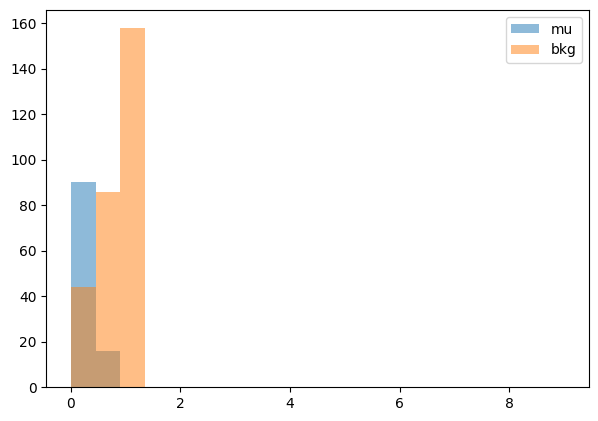

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7, 5), dpi=100)
plt.hist(pred_mu, bins=20,  alpha = 0.5, label = 'mu', range = [0,9])
plt.hist(pred_bkg, bins=20,  alpha = 0.5, label= 'bkg', range= [0,9])
plt.legend()
plt.show()


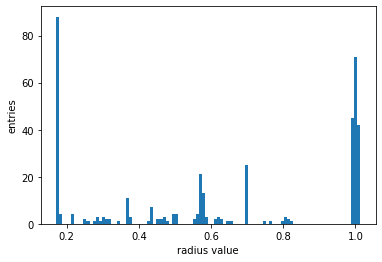

In [ ]:
import matplotlib.pyplot as plt 
r = predicted_radius.flatten()
plt.hist(r, bins=100)
plt.xlabel('radius value')
plt.ylabel('entries')
plt.show()